## Import statements

In [60]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
%matplotlib inline

## Extract data from titles

### Get file names

In [61]:
# Use relative file path to get directory of files"
path = "../raw_data/1-24 Audio Song and speech"

# Use os library to get file_names
directories = os.listdir(path)

### Process each filename to create arrays with important elements

In [63]:
# Initialize empty arrays for each field
speech_song = []
emotion = []
intensity = []
statement = []
repetitions = []
actor_id = []
gender = []

# Use for loop to process each file name.
for file in directories:
    f = file[0:-4]
    f = f.split("-")
    speech_song.append(f[1])
    emotion.append(f[2])
    intensity.append(f[3])
    statement.append(f[4])
    repetitions.append(f[5])
    actor_id.append(f[6])
    gender.append(int(f[6]) % 2)

### Create a dataframe with the array of elements

In [64]:
# Create the empty data frame.
df = pd.DataFrame()

# Create the columns in the dataframe using arrays
df["speech_song"] = speech_song
df["emotion"] = emotion
df["intensity"] = intensity
df["statement"] = statement
df["repetitions"] = repetitions
df["actor_id"] = actor_id
df["gender"] = gender

### Create string version of columns and dummy variables for emotions

In [65]:
# Create a gender in string version
df["gender_s"] = df["gender"].apply(lambda x: "Male" if x == 1 else "Female")


# Create an emotion dict to map the emotions
emotion_dict = {"01":"Neutral", "02":"Calm", "03":"Happy", "04":"Sad", "05":"Angry", "06":"Fearful"}

#Create a string column of the emotions and map them to emotion_dict
df["emotion_s"] = df["emotion"].map(emotion_dict)

# Get a dummies df of the emotions_strings
dummies = pd.get_dummies(df["emotion_s"])

# Horizontally concat the dummies df with original df.
df = pd.concat([df, dummies], axis=1)

df

,speech_song,emotion,intensity,statement,repetitions,actor_id,gender,gender_s,emotion_s,Angry,Calm,Fearful,Happy,Neutral,Sad
0,01,03,02,01,01,23,1,Male,Happy,0,0,0,1,0,0
1,01,04,02,02,02,15,1,Male,Sad,0,0,0,0,0,1
2,01,05,02,02,01,19,1,Male,Angry,1,0,0,0,0,0
3,01,03,02,01,02,07,1,Male,Happy,0,0,0,1,0,0
4,01,01,01,02,02,22,0,Female,Neutral,0,0,0,0,1,0
5,01,05,02,02,01,24,0,Female,Angry,1,0,0,0,0,0
6,01,03,02,02,02,18,0,Female,Happy,0,0,0,1,0,0
7,01,03,01,02,01,20,0,Female,Happy,0,0,0,1,0,0
8,02,01,01,02,01,24,0,Female,Neutral,0,0,0,0,1,0
9,02,06,02,02,01,19,1,Male,Fearful,0,0,1,0,0,0


## Getting spectograms from the signals

### Use librosa to create an array of signals

In [68]:
# Make an empty array with signals.
signals = []

# Use for loop to load every signal and append into array.
for file in directories:
    loaded_file, _ = librosa.load(path + "/" + file, duration= 2.9) # Use a duration of 2.9 so that the signals are all the same size
    signals.append(loaded_file)

### Make sure that all the shapes are the same

In [72]:
# Create an empty array to store first dimenstion of shapes.
shapes1 = []


# Use for loop to append dimension to array.
for signal in signals:
    shapes1.append(signal.shape[0])
    

# Transform the arrays into np.arrays    
shapes1 = np.array(shapes1)

# Print out the unique values of each array.
np.unique(shapes1)

array([63945])

### Define variables for spectograms

In [29]:
# Define a frame size
FRAME_SIZE = 2048

# Define a hop size.
HOP_SIZE = 512

# Define the default sampling rate of librosa
sr = 22050

### Create a function that will create spectograms

In [81]:
def create_spectogram(signal, frame_size, hop_lngth):
    """Define a function that given a signal will create a logarithmic spectogram in decibels."""
    
    # Create a complex spectogram with short time fourier transform
    complex_spectogram = librosa.stft(signal, n_fft = frame_size, hop_length= hop_lngth)
    
    # Get only the magnitudes of the complex spectogram
    spectogram = np.abs(complex_spectogram)**2
    
    # Scale the spectogram into decibes (logarithmic)
    log_spectogram = librosa.power_to_db(spectogram)
    
    # Return the logarithmic spectogram.
    return log_spectogram

### Create function that plots spectograms

In [37]:
def plot_spectogram(Y, sr, hop_length, y_axis= "linear"):
    """Function that plots a spectogram with linear default y_axis"""
    
    # Define the figure size
    plt.figure(figsize=(25,10))
    #Use librosa library to plot spectogram.
    librosa.display.specshow(Y,
                             sr=sr,
                             hop_length= hop_length,
                             x_axis="time",
                             y_axis=y_axis
                            )
    # Adda a colorbar to the plot
    plt.colorbar(format="%+2.f")

### Create an array of log spectograms using the create_spectogram function

In [82]:
# Create empty array to store log spectograms
spectograms = []

# Use for loop to create spectograms and append them to the spectograms array
for signal in signals:
    spectogram = create_spectogram(signal, FRAME_SIZE, HOP_SIZE)
    spectograms.append(spectogram)

### Make sure that the spectograms have the same shapes

In [86]:
# Create an empty array to store first dimenstion of shapes.
shapes1 = []
shapes2 = []


# Use for loop to append dimension to array.
for spectogram in spectograms:
    shapes1.append(spectogram.shape[0])
    shapes2.append(spectogram.shape[1])
    
# Transform the arrays into np.arrays    
shapes1 = np.array(shapes1)
shapes2 = np.array(shapes2)

# Print out the unique values of each array.
np.unique(shapes1)
np.unique(shapes2)

array([125])

### Plot first spectogram as an example

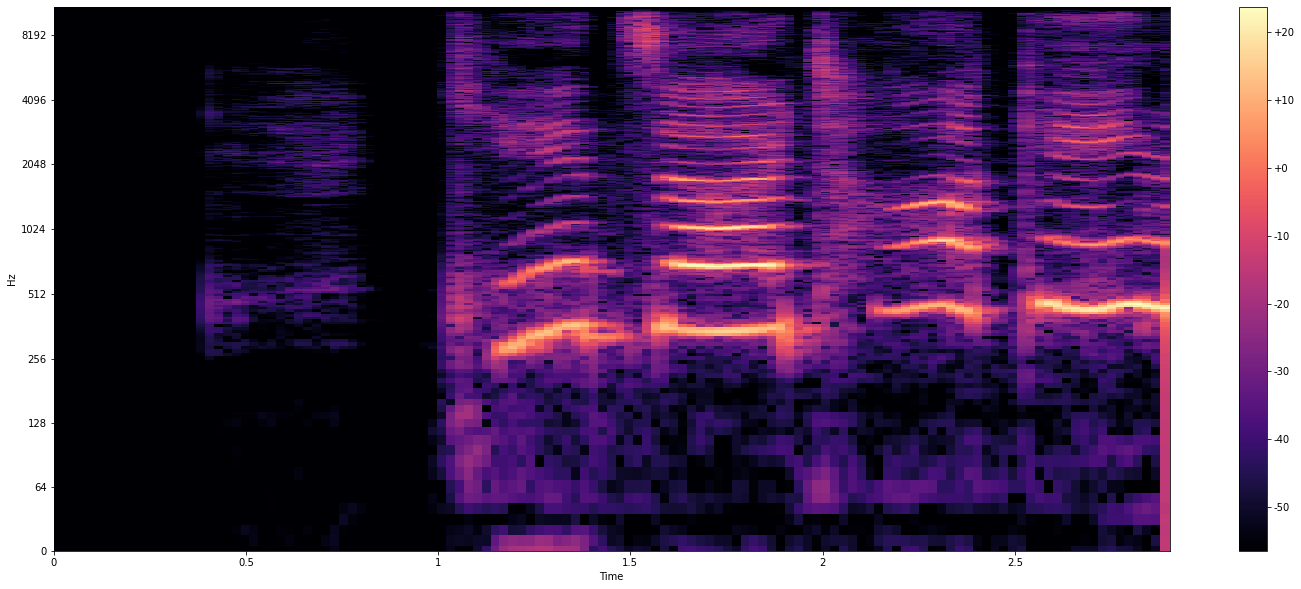

In [92]:
plot_spectogram(spectograms[100], sr, HOP_SIZE, y_axis="log")

## Getting mel-spectograms from the signals

### Create function to extract mel spectograms

In [93]:
def create_mel_spectogram(signal, sr, n_fft, hop_size, n_mels):
    """Function that creates a log mel spectogram"""
    
    # Get vanilla mel spectogram
    mel_spectogram = librosa.feature.melspectrogram(signal, sr=sr, n_fft= n_fft, hop_length= hop_size, n_mels= n_mels)
    
    # Transform vanilla mel spectogram into log spectogram.
    log_mel_spectogram = librosa.power_to_db(mel_spectogram)
    
    return log_mel_spectogram

### Create function to plot mel spectograms

In [95]:
def plot_mel_spectogram(Y, sr, hop_length):
    """Function that plots a spectogram"""
    
    # Define the figure size
    plt.figure(figsize=(25,10))
    #Use librosa library to plot mel_spectogram.
    librosa.display.specshow(Y,
                             sr=sr,
                             hop_length= hop_length,
                             x_axis="time",
                             y_axis="mel"
                            )
    # Adda a colorbar to the plot
    plt.colorbar(format="%+2.f")

### Create mel spectograms from each signal